In [14]:
import glob
import random
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from datetime import datetime
import time
import os

import pprint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

Check if GPUs are available

In [15]:
print("GPUs: ", tf.config.list_physical_devices('GPU'))

GPUs:  []


Find data files recursively from root folder.

In [16]:
data_path = "D:/Coding/Thesis/Data/STFT Output/**/*.h5"
data_files = glob.glob(data_path, recursive=True)

In [17]:
config = {}

config['model_folder'] = 'D:/Coding/Thesis/movement_prediction/Models/'

config['EEG_window_length_in_ms'] = 30000

Next, we configure the output layer of the LSTM:


`delta_time_k` predicts the delta time to the next $k^{th}$ tap.

`tap_count_times_p` predicts the *number of taps* within the next $p$ seconds.

In [18]:
config['delta_time_k'] = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
config['tap_count_times_p'] = np.array([0.5, 1, 5, 10, 50, 100, 500])

config['read_config_from_h5'] = True

config['EEG_sampling_rate'] = 1000
config['stft_stride'] = 128
config['sampling_rate_after_stft'] = config['EEG_sampling_rate'] / config['stft_stride']
config['sample_length_after_stft'] = 1000 / config['sampling_rate_after_stft']

config['tap_count_times_in_samples'] = np.multiply(config['tap_count_times_p'], config['EEG_sampling_rate'])

# Load data into memory

Instead of loading data from the h5 file when we need it, we load all the data of a single participant into memory (because it fits and it's easier)

In [19]:
def load_data(h5_files):
    EEG, taps = [], []
    
    # Makes sure that if a single file is passed in, it is put into a list
    if type(h5_files) != 'list':
        h5_files = [h5_files]
    
    for f in h5_files:
        with h5py.File(f, 'r') as f_open:
            if config['read_config_from_h5']:
                    config['EEG_sampling_rate'] = f_open.attrs['original_sampling_rate']
                    config['stft_stride'] = f_open.attrs['stft_hopsize']
            
            for session in list(f_open.keys()):
                for activity_window in list(f_open[session].keys()):
                    if activity_window.startswith('window_'):
                        EEG.append(np.array(f_open[session][activity_window]['stft'], dtype='float32'))
                        taps.append(np.array(f_open[session][activity_window]['taps']))
    
    ############# Inf found in data!
    for i in EEG:
        i[np.isinf(i)] = 0
    
    return (EEG, taps)

stft, taps = load_data('D:\\Coding\\Thesis\\Data\\STFT Output\\DS99.h5')

config['window_length_sftf_samples'] = np.ceil(30000 / 1000 * config['EEG_sampling_rate'] / config['stft_stride'])[0]

print(config['window_length_sftf_samples'])
print(f'Number of activity windows: {len(stft)}')
print([x.shape for x in stft])

235.0
Number of activity windows: 7
[(64, 12300, 11), (64, 17318, 11), (64, 941, 11), (64, 802, 11), (64, 649, 11), (64, 649, 11), (64, 7450, 11)]


Remove all activity windows that are shorter than 10 * a single window length.



In [20]:
def normalize_input(_input):
    # stft: A list of np arrays.
    stft_cat = np.concatenate(_input, axis=1)
    
    print(f'NaN: {np.sum(np.isnan(stft_cat))}')
    print(f'Inf: {np.sum(np.isinf(stft_cat))}')
    
    means = np.mean(stft_cat, axis=(0, 1), keepdims=True)
    st_devs = np.std(stft_cat, axis=(0, 1), keepdims=True)
    
    out = [(i - means) - st_devs for i in _input]
    
    return out

stft_norm = normalize_input(stft)

NaN: 0
Inf: 0


## The DataLoader class
The DataLoader class contains and acts on participant data. It knows about the structure of the h5 files and can return random windows of EEG activity and taps, i.e., training data.

The stft data in the h5 files is 3-dimensional:
1. EEG channel
2. EEG timeseries
3. STFT frequency bins

In [21]:
class DataLoader(keras.utils.Sequence):
    def __init__(self, x, y, window_length=30000, batch_size=32, n_samples=2000, shuffle=True):
        self.x = x
        self.y = y
        self.window_length = window_length
        self.batch_size = batch_size
        self.n_samples = n_samples
        self.shuffle = shuffle
        
        self.subset_probabilities = self._get_subset_probabilites(x)
    
    
    def __len__(self):
        win_lengths = [win.shape[1] for win in self.x]
        return sum(win_lengths) // self.batch_size
    
    
    def __getitem__(self, index):
        '''
        Get a single item from a Sequence.
        '''
        
        # For testing only
        #return np.random.rand(self.batch_size, 938, 2048), np.random.rand(self.batch_size, 17)
        
        X = []
        Y = []
        
        for batch in range(self.batch_size):
            if self.shuffle:
                # Pick random activity window
                # Since subsets are of different length and contain different amounts of data,
                # we need to adjust the probability of each subset being picked to its length.
                subset_idx = np.random.choice(len(self.x), p = self.subset_probabilities)

                # Pick random EEG window
                window_length_in_samples = np.ceil(self.window_length / config['stft_stride']).astype(np.int)

                window_end_idx = np.random.randint(window_length_in_samples, self.x[subset_idx].shape[1])       
                window_idx_stft = np.arange(window_end_idx - window_length_in_samples, window_end_idx, dtype=np.int)        

                input_data = np.array(self.x[subset_idx][:, window_idx_stft, :])
                
                # Get appropriate tap info        
                window_end_idx_tap_adjusted = np.ceil(np.array(window_end_idx) * config['sampling_rate_after_stft']).astype(np.int)

                output_data = self.get_taps_in_window(self.y[subset_idx], window_end_idx_tap_adjusted)
            else:
                subset_idx = index[0]
                
                # EEG data
                window_length_in_samples = np.ceil(self.window_length / config['stft_stride']).astype(np.int)
                window_idx_stft = np.arange(index - window_length_in_samples, index, dtype=np.int)
                input_data = np.array(self.x[subset_idx][:, window_idx_stft, :])
                
                # Tap data
                window_end_idx_tap_adjusted = np.ceil(np.array(index[1]) * config['sampling_rate_after_stft']).astype(np.int)
                output_data = self.get_taps_in_window(self.y[subset_idx], window_end_idx_tap_adjusted)
            
            # Move Time information to first axis
            input_data = np.moveaxis(input_data, 1, 0)
            
            # Reshape multidimensional features into a single dimension
            input_data = np.reshape(input_data, (input_data.shape[0], np.prod(input_data.shape[1:3])))
            
            
            
            X.append(input_data)
            Y.append(output_data)
                
        # Convert list of samples into a 3D array.
        # The first dimension is the sample, second dimension the timesteps, third dimension the features
        X = np.array(X)
        Y = np.array(Y)
        
        # Warn if any NaN detected in data
        if np.any(np.isnan(X)):
            print('NaN values found in X!')
        if np.any(np.isnan(Y)):
            print('NaN values found in Y!')
                
        return X, Y
    
    def on_epoch_end(self):
        pass
    
    def _get_subset_probabilites(self, x):
        lengths = np.array([win.shape[1] for win in x])
        
        return lengths / sum(lengths)
        
    
    def get_taps_in_window(self, taps, window_end):      
        tap_deltas = self.get_delta_taps(taps, window_end)
        
        future_tap_n = self.get_n_future_taps(taps, window_end)
        
        result = np.concatenate((tap_deltas, future_tap_n))

        # Convert values to log to avoid huge values
        result = [np.log10(tap) if tap > 0 else tap for tap in result]
        
        threshold_ms = 1
        result = np.maximum(result, np.log10(threshold_ms))
        
        return result
    
    
    def get_delta_taps(self, taps, window_idx):
        n_k = len(config['delta_time_k'])
        
        next_kth_taps = taps[taps > window_idx][:n_k]
        
        # Ensure that if not enough taps were found the array is padded with 0s.
        # This only occurs 
        if len(next_kth_taps) < n_k:
            next_kth_taps = np.concatenate((next_kth_taps, np.zeros(n_k - len(next_kth_taps))))
        
        tap_deltas = next_kth_taps - window_idx
        
        return tap_deltas
            
    
    def get_n_future_taps(self, taps, window_idx):
        n_future_taps = np.zeros(len(config['tap_count_times_in_samples']))
        
        for p_idx, p in enumerate(config['tap_count_times_in_samples']):
            n_future_taps[p_idx] = len(
                taps[
                    (taps > window_idx) &
                    (taps <= (window_idx + p))
                ]
            )
        
        return n_future_taps

# Determining the in- and outputs of the LSTM
Next, we check the sizes that are returned by our data generation function.

## Generate train, validation, and test set

In [22]:
stft_norm_train = []
stft_norm_validation = []
stft_norm_test = []

taps_train, taps_validation, taps_test = [], [], []

for i, x in enumerate(stft_norm):
    x_len = x.shape[1]
    
    # Check if activity window length is too short.
    # If so, add it to train set.
    # If extremely short, discard window
    if x_len < (config['window_length_sftf_samples'] * 3):
        continue
        
    elif x_len < (config['window_length_sftf_samples'] * 10):
        stft_norm_train.append(x)
        taps_train.append(np.array(taps[i]))
        
        continue
    
    train_idx = range(0, (x_len//10 * 8))
    validation_idx = range((x_len//10 * 8), (x_len//10 * 9))
    test_idx = range((x_len//10 * 9), x_len)
    
    stft_norm_train.append(x[:, train_idx, :])
    stft_norm_validation.append(x[:, validation_idx, :])
    stft_norm_test.append(x[:, test_idx, :])
    
    # Add taps
    _taps = np.array(taps[i])
    
    _taps_train = _taps[np.logical_and(_taps > (train_idx[0] * config['sampling_rate_after_stft']), \
                                       _taps < (train_idx[-1] * config['sampling_rate_after_stft']))]
    
    _taps_vali = _taps[np.logical_and(_taps > (validation_idx[0] * config['sampling_rate_after_stft']), \
                                      _taps < (validation_idx[-1] * config['sampling_rate_after_stft']))]
    
    _taps_test = _taps[np.logical_and(_taps > (test_idx[0] * config['sampling_rate_after_stft']), \
                                      _taps < (test_idx[-1] * config['sampling_rate_after_stft']))]
    
    # Adjust tap timings to zero at beginning of sequence
    _taps_train = _taps_train - (train_idx[0] * config['sampling_rate_after_stft'])
    _taps_vali = _taps_vali - (validation_idx[0] * config['sampling_rate_after_stft'])
    _taps_test = _taps_test - (test_idx[0] * config['sampling_rate_after_stft'])
    
    taps_train.append(_taps_train)
    taps_validation.append(_taps_vali)
    taps_test.append(_taps_test)
    
print([x.shape for x in stft_norm_test])


# 10% of data for validation
# 10% of data for testing

[(64, 1230, 11), (64, 1739, 11), (64, 745, 11)]


## Create DataGenerators for train, validation, and test

In [23]:
ppt_train = DataLoader(stft_norm_train, taps_train, batch_size=32)

ppt_validation = DataLoader(stft_norm_validation, taps_validation, batch_size=32)

ppt_test = DataLoader(stft_norm_test, taps_test, batch_size=32)

In [24]:
my_batch_x, my_batch_y = ppt_train[0] # get a random batch

And do a sanity check on the content of the generated target data.

Input layer dimensions: (32, 235, 704)
Output layer dimensions: (32, 17)
Output layer values: [3.03782475 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


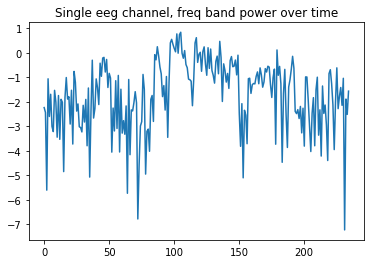

In [25]:
np.set_printoptions(suppress=True)

print(f'Input layer dimensions: {my_batch_x.shape}')
print(f'Output layer dimensions: {my_batch_y.shape}')
print(f'Output layer values: {my_batch_y[0]}')

plt.plot(my_batch_x[0, :, 0].T)
plt.title('Single eeg channel, freq band power over time')
plt.show()

## Input layer
The ParticipantData class generates an input information that is $938 \times 64 \times 32$ in size. Since the first dimension is the temporal information, the LSTM's input layer has a size of $64 \times 32 = 2048$ and takes a window of 938 samples at a time.

This conversion from window length in ms to window length in STFT samples can be calculated by the following formula:

$$
\bigl\lceil
\frac{\frac{\text{T}}{1000} \text{Fs}}
{\text{R}}
\bigr\rceil
$$

, where $T$ is the window length in ms, $Fs$ is the original sampling rate, and $R$ is the hopsize of the STFT.

## Output layer
The ParticipantData class also generates training output. The output layer has a length of 17. It is composed of the $\Delta t$ to the next $k$ steps in ms, as well as the number of taps within the next $p$ seconds. Which and how many $k$ and $p$ are predicted is defined in the config dictionary at the top of the script. The size of the output layer is defined as $|K| + |P|$

# LSTM
## Configure LSTM

In [26]:
model_file = ''

load_latest = True

if load_latest:
    files = [os.path.join(config['model_folder'], f) for f in os.listdir(config['model_folder']) if (f.lower().endswith('.h5'))]
    file_mtimes = [os.path.getmtime(f) for f in files]
    
    files.sort(key=os.path.getmtime, reverse=True)
    
    model_file = files[0]
if model_file != '':
    model = keras.models.load_model(model_file)
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               426496    
_________________________________________________________________
dense (Dense)                (None, 17)                2193      
Total params: 428,689
Trainable params: 428,689
Non-trainable params: 0
_________________________________________________________________


In [36]:
LSTM_config = {
    'input_layer_size': np.prod([stft[0].shape[0], stft[0].shape[2]]),
    'output_layer_size': np.hstack([config['delta_time_k'], config['tap_count_times_p']]).shape[0]
}

print(LSTM_config)

model = keras.Sequential()

model.add(keras.Input(shape=(None, LSTM_config['input_layer_size'])))
model.add(layers.Conv1D(filters=LSTM_config['input_layer_size'],
                        kernel_size=3))
model.add(layers.LSTM(units=128,
                      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                      bias_regularizer=regularizers.l2(1e-4),))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.02))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.02))
model.add(layers.Dense(LSTM_config['output_layer_size'], ))

model.summary()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=100,
    decay_rate=0.95)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='mean_squared_error', optimizer=opt)

{'input_layer_size': 704, 'output_layer_size': 17}
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, None, 704)         1487552   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               426496    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
den

### Fit model

In [37]:
model.fit(ppt_train, epochs=3, steps_per_epoch=100, verbose=1)

Epoch 1/3
100/100 [==============================] - 60s 599ms/step - loss: 2.0825
Epoch 2/3
100/100 [==============================] - 62s 618ms/step - loss: 1.8287
Epoch 3/3
100/100 [==============================] - 65s 649ms/step - loss: 1.8970


In [20]:
time_now = datetime.now().strftime('%d.%m.%Y_%H.%M.%S')

save_location = config['model_folder'] + 'mov_pred_model_' + time_now + '.h5'

print(f'Saving model at {save_location}')
model.save(save_location)
print(f'Model done saving.')

Saving model at D:/Coding/Thesis/movement_prediction/Models/mov_pred_model_09.03.2021_16.48.03.h5
Model done saving.


## Plot model prediction against true values

In [41]:
_x, _y = ppt_train[0]

y_hat = model.predict_on_batch(_x)

print(np.std(y_hat, axis=0))

[0.09486433 0.09172642 0.09358506 0.08911672 0.09047854 0.09375779
 0.08655559 0.08159751 0.07510114 0.09032164 0.01673871 0.00763499
 0.01209184 0.01146911 0.02142619 0.02635783 0.03244393]


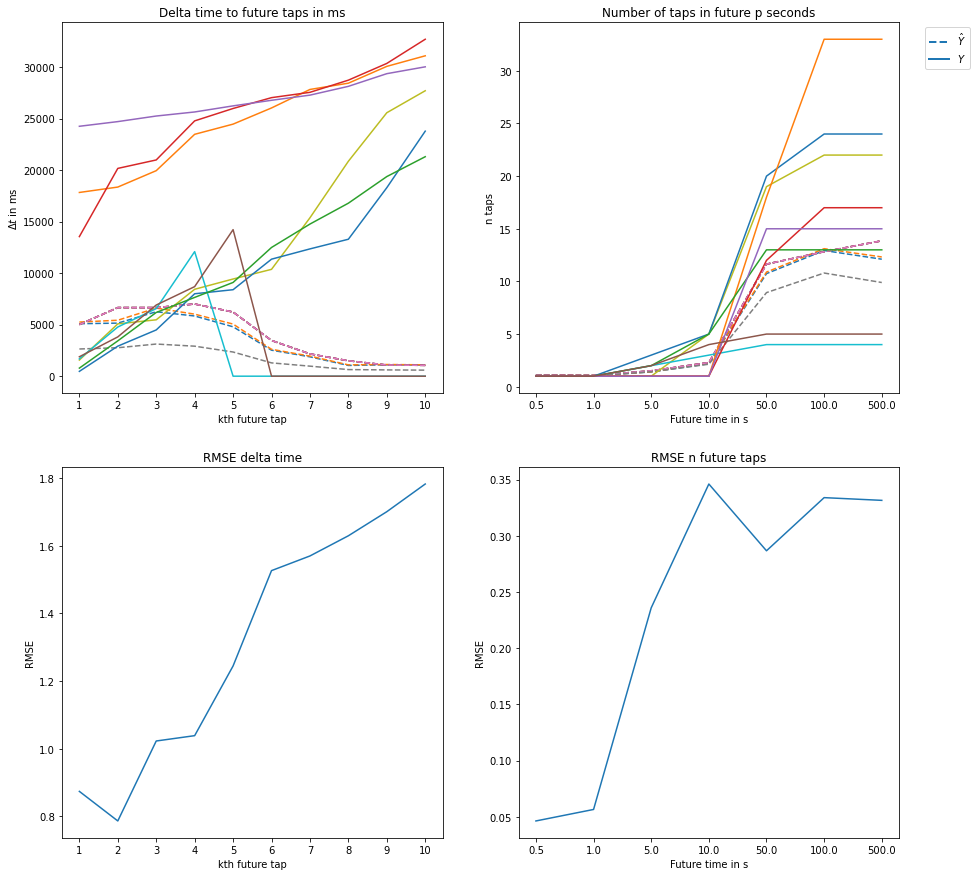

In [42]:
%matplotlib inline

batch_id = np.arange(8)

RMSE = np.sqrt(((y_hat - _y) ** 2).mean(0))

fig, ((deltas_plt, n_taps_plt), (RMSE_deltas_plt, RMSE_ntaps_plt)) = plt.subplots(2, 2, figsize=(15, 15))

# Generate rainbow colors
colors = mpl.cm.rainbow


# Mean plots
deltas_plt.plot(10 ** y_hat[batch_id, 0:10].T, '--')
#deltas_plt.fill_between(np.arange(len(config['delta_time_k'])),
#                        10 ** np.min(y_hat[:, 0:10], axis=0),
#                        10 ** np.max(y_hat[:, 0:10], axis=0))

deltas_plt.plot(10 ** _y[batch_id, 0:10].T)
deltas_plt.set(title='Delta time to future taps in ms',
               xlabel='kth future tap',
               ylabel='$\Delta t$ in ms')
plt.sca(deltas_plt)
plt.xticks(np.arange(len(config['delta_time_k'])), config['delta_time_k'])

n_taps_plt.plot(10 ** y_hat[batch_id, 10:].T, '--')
n_taps_plt.plot(10 ** _y[batch_id, 10:].T)
n_taps_plt.set(title='Number of taps in future p seconds',
               xlabel='Future time in s',
               ylabel='n taps')
plt.sca(n_taps_plt)
plt.xticks(np.arange(len(config['tap_count_times_p'])), config['tap_count_times_p'])

custom_legend_items = [mpl.lines.Line2D([0], [0], lw=2, ls='--'),
                       mpl.lines.Line2D([0], [0], lw=2, ls='-')]
plt.legend(custom_legend_items, [r'$\hat{Y}$', r'$Y$'], bbox_to_anchor=(1.2, 1), loc=1)



# RMSE plots
RMSE_deltas_plt.plot(RMSE[:10])
RMSE_deltas_plt.set(title='RMSE delta time',
               xlabel='kth future tap',
               ylabel='RMSE')
plt.sca(RMSE_deltas_plt)
plt.xticks(np.arange(len(config['delta_time_k'])), config['delta_time_k'])

RMSE_ntaps_plt.plot(RMSE[10:])
RMSE_ntaps_plt.set(title='RMSE n future taps',
               xlabel='Future time in s',
               ylabel='RMSE')
plt.sca(RMSE_ntaps_plt)
plt.xticks(np.arange(len(config['tap_count_times_p'])), config['tap_count_times_p'])



plt.show()

In [56]:
k = np.vstack([ppt[i][1] for i in range(40)])

NameError: name 'ppt' is not defined

In [ ]:
plt.scatter(np.linspace(1, 18, 17), 10 ** k.mean(0))
plt.show()